In [1]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

In [2]:
data = pd.read_excel("data/data.xlsx")

Подготовка признаков и целевой переменной

In [3]:
target = "SI"
threshold = 8
y = (data[target] > threshold).astype(int)  # бинаризация

X = data.drop(
    columns=[
        target,
        "IC50, mM",
        "CC50, mM",
        "log10_IC50, mM",
        "log10_CC50, mM",
        "log10_SI",
    ],
    errors="ignore",
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Модели и гиперпараметры

In [4]:
models_params = {
    "LogReg": {
        "model": Pipeline(
            [
                ("scaler", StandardScaler()),
                ("logreg", LogisticRegression(max_iter=5000)),
            ]
        ),
        "params": {"logreg__C": [0.01, 0.1, 1, 10]},
    },
    "RandomForest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [5, 10, None],
            "min_samples_split": [2, 5],
        },
    },
    "XGBoost": {
        "model": xgb.XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=42
        ),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [3, 5],
            "learning_rate": [0.01, 0.1],
        },
    },
}

Обучение и подбор гиперпараметров

In [5]:
results = []
best_models = {}

for name, mp in models_params.items():
    print(f"Обучение модели: {name}")
    grid = GridSearchCV(mp["model"], mp["params"], cv=5, scoring="roc_auc", n_jobs=-1)
    grid.fit(X_train, y_train)

    y_pred = grid.predict(X_test)
    y_proba = grid.predict_proba(X_test)[:, 1]

    results.append(
        {
            "Model": name,
            "Best_Params": grid.best_params_,
            "Accuracy": accuracy_score(y_test, y_pred),
            "Precision": precision_score(y_test, y_pred),
            "Recall": recall_score(y_test, y_pred),
            "F1": f1_score(y_test, y_pred),
            "ROC_AUC": roc_auc_score(y_test, y_proba),
        }
    )

    best_models[name] = grid

results_df = pd.DataFrame(results).sort_values(by="ROC_AUC", ascending=False)
display(results_df)

Обучение модели: LogReg
Обучение модели: RandomForest
Обучение модели: XGBoost


c:\Users\mdubr\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:1135: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(


,Model,Best_Params,Accuracy,Precision,Recall,F1,ROC_AUC
1,RandomForest,"{'max_depth': 5, 'min_samples_split': 2, 'n_es...",0.721649,0.674419,0.420290,0.517857,0.723826
0,LogReg,{'logreg__C': 10},0.695876,0.586207,0.492754,0.535433,0.707362
2,XGBoost,"{'learning_rate': 0.01, 'max_depth': 3, 'n_est...",0.690722,0.666667,0.260870,0.375000,0.704986


In [6]:
# Автоматический выбор лучшей модели по ROC_AUC
best_idx = results_df["ROC_AUC"].idxmax()
best_model_name = results_df.loc[best_idx, "Model"]
best_model = best_models[best_model_name]

print(f"Лучшая модель: {best_model_name}")

Лучшая модель: RandomForest


In [7]:
import matplotlib.pyplot as plt

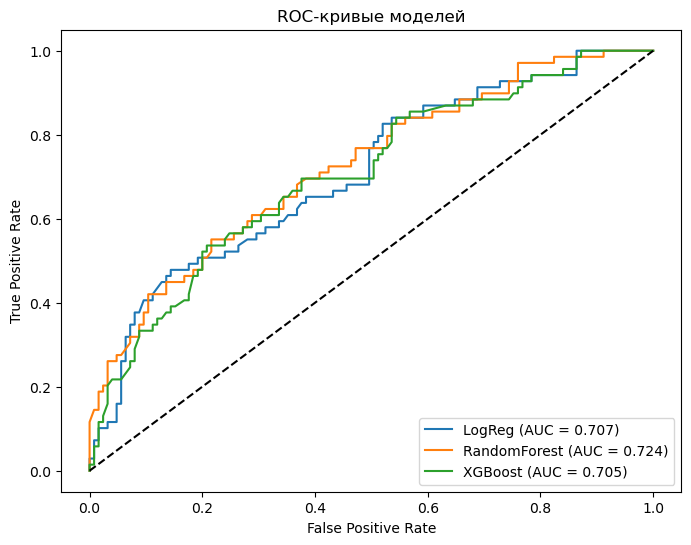

In [8]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(8, 6))

for name, grid in best_models.items():
    # вероятности положительного класса
    if hasattr(grid, "predict_proba"):
        y_proba = grid.predict_proba(X_test)[:, 1]
    else:
        # для моделей без predict_proba можно использовать decision_function
        y_proba = grid.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

# диагональ случайного классификатора
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC-кривые моделей")
plt.legend(loc="lower right")
plt.show()

<Figure size 600x600 with 0 Axes>

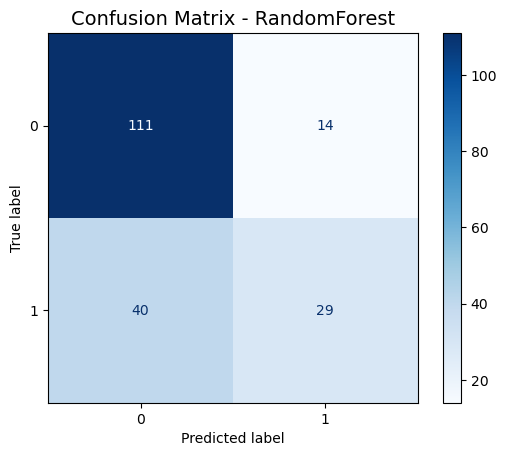

In [9]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

plt.figure(figsize=(6, 6))
disp.plot(cmap="Blues", values_format="d")
plt.title(f"Confusion Matrix - {best_model_name}", fontsize=14)
plt.show()